# Bitcoin Whale Intelligence Analysis

**Standalone Analysis Notebook** - No external dependencies except Python, PySpark, and GraphFrames.

| Section | Description |
|---------|-------------|
| 1. Setup & Configuration | Imports, paths, and Spark initialization |
| 2. Helper Functions | All ETL functions (inline, no external imports) |
| 3. Data Loading | Load blockchain data from bitcoin-etl exports |
| 4. Entity Clustering | Group addresses using graph analysis |
| 5. Results & Visualization | Whale identification and charts |
| 6. Executive Summary | Key findings and metrics |

---
## 1. Setup & Configuration

In [1]:
# ==============================================================================
# IMPORTS
# ==============================================================================
import os
import platform
from pathlib import Path
from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import (
    col, count, sum as spark_sum, avg, desc, when, round as spark_round,
    explode, explode_outer, collect_set, size as spark_size,
    from_unixtime, to_timestamp, element_at
)
from pyspark.sql.types import (
    StructType, StructField, StringType, LongType, IntegerType,
    BooleanType, ArrayType
)
from pyspark.sql.functions import udf

# Visualization style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.figsize': (12, 6),
    'figure.dpi': 100,
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'axes.labelsize': 11,
    'font.size': 10
})
COLORS = {'primary': '#2E86AB', 'secondary': '#A23B72', 'accent': '#F18F01', 'dark': '#1B1B1E'}

In [2]:
# ==============================================================================
# CONFIGURATION - ADJUST PATHS FOR YOUR SYSTEM
# ==============================================================================

SYSTEM = platform.system()

# Path to bitcoin-etl exported data
# Examples:
#   Windows: r"C:\Users\YourName\blockchain_exports"
#   macOS:   "/Users/YourName/blockchain_exports"
#   Linux:   "/home/YourName/blockchain_exports"

if SYSTEM == "Windows":
    BLOCKCHAIN_DATA_PATH = r"C:\Users\YourName\blockchain_exports"  # <-- CHANGE THIS
    OUTPUT_PATH = r"C:\Users\YourName\bitcoin_analysis_output"       # <-- CHANGE THIS
elif SYSTEM == "Darwin":  # macOS
    BLOCKCHAIN_DATA_PATH = "/Users/roman/spark_project/blockchain_exports"  # <-- CHANGE THIS
    OUTPUT_PATH = "/Users/roman/spark_project/bitcoin-whale-intelligence/data"
else:  # Linux
    BLOCKCHAIN_DATA_PATH = "/home/YourName/blockchain_exports"  # <-- CHANGE THIS
    OUTPUT_PATH = "/home/YourName/bitcoin_analysis_output"

DRIVER_MEMORY = "16g"

# Create output directory
Path(OUTPUT_PATH).mkdir(parents=True, exist_ok=True)

print(f"System: {SYSTEM}")
print(f"Data source: {BLOCKCHAIN_DATA_PATH}")
print(f"Output path: {OUTPUT_PATH}")

System: Darwin
Data source: /Users/roman/spark_project/blockchain_exports
Output path: /Users/roman/spark_project/bitcoin-whale-intelligence/data


---
## 2. Helper Functions

All ETL functions defined inline for standalone execution.

In [3]:
# ==============================================================================
# SCHEMAS FOR BITCOIN-ETL JSON DATA
# ==============================================================================

INPUT_SCHEMA = StructType([
    StructField("index", IntegerType(), True),
    StructField("spent_transaction_hash", StringType(), True),
    StructField("spent_output_index", IntegerType(), True),
    StructField("script_asm", StringType(), True),
    StructField("script_hex", StringType(), True),
    StructField("sequence", LongType(), True),
    StructField("required_signatures", IntegerType(), True),
    StructField("type", StringType(), True),
    StructField("addresses", ArrayType(StringType()), True),
    StructField("value", LongType(), True),
])

OUTPUT_SCHEMA = StructType([
    StructField("index", IntegerType(), True),
    StructField("script_asm", StringType(), True),
    StructField("script_hex", StringType(), True),
    StructField("required_signatures", IntegerType(), True),
    StructField("type", StringType(), True),
    StructField("addresses", ArrayType(StringType()), True),
    StructField("value", LongType(), True),
])

TRANSACTION_SCHEMA = StructType([
    StructField("hash", StringType(), False),
    StructField("size", IntegerType(), True),
    StructField("virtual_size", IntegerType(), True),
    StructField("version", IntegerType(), True),
    StructField("lock_time", LongType(), True),
    StructField("block_number", LongType(), True),
    StructField("block_hash", StringType(), True),
    StructField("block_timestamp", LongType(), True),
    StructField("is_coinbase", BooleanType(), True),
    StructField("index", IntegerType(), True),
    StructField("inputs", ArrayType(INPUT_SCHEMA), True),
    StructField("outputs", ArrayType(OUTPUT_SCHEMA), True),
    StructField("input_count", IntegerType(), True),
    StructField("output_count", IntegerType(), True),
    StructField("input_value", LongType(), True),
    StructField("output_value", LongType(), True),
    StructField("fee", LongType(), True),
])

BLOCK_SCHEMA = StructType([
    StructField("hash", StringType(), False),
    StructField("size", IntegerType(), True),
    StructField("stripped_size", IntegerType(), True),
    StructField("weight", IntegerType(), True),
    StructField("number", LongType(), True),
    StructField("version", IntegerType(), True),
    StructField("merkle_root", StringType(), True),
    StructField("timestamp", LongType(), True),
    StructField("nonce", StringType(), True),
    StructField("bits", StringType(), True),
    StructField("coinbase_param", StringType(), True),
    StructField("transaction_count", IntegerType(), True),
])

print("Schemas defined.")

Schemas defined.


In [4]:
# ==============================================================================
# Helper Functions
# ==============================================================================

def create_spark_session(app_name="Bitcoin Whale Intelligence", driver_memory="8g",
                         enable_graphframes=True, suppress_logs=True):
    """
    Create an optimized Spark session for Bitcoin data processing.
    """
    builder = SparkSession.builder \
        .appName(app_name) \
        .master("local[*]") \
        .config("spark.driver.memory", driver_memory) \
        .config("spark.driver.maxResultSize", "4g") \
        .config("spark.sql.adaptive.enabled", "true") \
        .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
        .config("spark.sql.adaptive.skewJoin.enabled", "true") \
        .config("spark.sql.shuffle.partitions", "200") \
        .config("spark.sql.debug.maxToStringFields", "100") \
        .config("spark.ui.showConsoleProgress", "false") \
        .config("spark.memory.fraction", "0.8") \
        .config("spark.memory.storageFraction", "0.3")

    if enable_graphframes:
        builder = builder.config(
            "spark.jars.packages",
            "graphframes:graphframes:0.8.3-spark3.5-s_2.12"
        )

    if suppress_logs:
        devnull = os.open(os.devnull, os.O_WRONLY)
        old_stdout_fd = os.dup(1)
        old_stderr_fd = os.dup(2)
        os.dup2(devnull, 1)
        os.dup2(devnull, 2)
        try:
            spark = builder.getOrCreate()
            spark.sparkContext.setLogLevel("ERROR")
        finally:
            os.dup2(old_stdout_fd, 1)
            os.dup2(old_stderr_fd, 2)
            os.close(devnull)
            os.close(old_stdout_fd)
            os.close(old_stderr_fd)
    else:
        spark = builder.getOrCreate()
        spark.sparkContext.setLogLevel("ERROR")

    return spark


def load_transactions(spark, base_path, use_schema=True):
    """
    Load bitcoin-etl transaction data from Hive-partitioned JSON files.
    """
    base = Path(base_path)
    batch_folders = [d for d in base.iterdir() if d.is_dir() and not d.name.startswith('.')]

    if not batch_folders:
        raise ValueError(f"No batch folders found in {base_path}")

    tx_paths = []
    for batch in batch_folders:
        tx_path = batch / "transactions"
        if tx_path.exists():
            tx_paths.append(str(tx_path))

    if not tx_paths:
        raise ValueError("No transactions/ folders found")

    if use_schema:
        df = spark.read.schema(TRANSACTION_SCHEMA).json(tx_paths)
    else:
        df = spark.read.json(tx_paths)

    df = df.withColumn("block_datetime", to_timestamp(from_unixtime(col("block_timestamp"))))
    return df


def load_blocks(spark, base_path, use_schema=True):
    """
    Load bitcoin-etl block data from Hive-partitioned JSON files.
    """
    base = Path(base_path)
    batch_folders = [d for d in base.iterdir() if d.is_dir() and not d.name.startswith('.')]

    block_paths = []
    for batch in batch_folders:
        block_path = batch / "blocks"
        if block_path.exists():
            block_paths.append(str(block_path))

    if not block_paths:
        raise ValueError("No blocks/ folders found")

    if use_schema:
        df = spark.read.schema(BLOCK_SCHEMA).json(block_paths)
    else:
        df = spark.read.json(block_paths)

    df = df.withColumn("timestamp_dt", to_timestamp(from_unixtime(col("timestamp"))))
    return df


def explode_outputs(tx_df):
    """
    Transform nested outputs to a flat table.
    """
    return tx_df \
        .select(
            col("hash").alias("tx_hash"),
            col("block_number"),
            col("block_timestamp"),
            explode_outer("outputs").alias("output")
        ) \
        .select(
            "tx_hash",
            "block_number",
            "block_timestamp",
            col("output.index").alias("output_index"),
            col("output.value").alias("value"),
            col("output.addresses").alias("addresses"),
            col("output.type").alias("output_type"),
        )


def explode_inputs(tx_df):
    """
    Transform nested inputs to a flat table.
    """
    return tx_df \
        .select(
            col("hash").alias("tx_hash"),
            col("block_number"),
            col("block_timestamp"),
            col("is_coinbase"),
            explode_outer("inputs").alias("input")
        ) \
        .select(
            "tx_hash",
            "block_number",
            "block_timestamp",
            "is_coinbase",
            col("input.index").alias("input_index"),
            col("input.spent_transaction_hash").alias("spent_tx_hash"),
            col("input.spent_output_index").alias("spent_output_index"),
            col("input.addresses").alias("addresses"),
            col("input.value").alias("value"),
        )


def compute_utxo_set(outputs_df, inputs_df):
    """
    Compute UTXO Set (Unspent Transaction Outputs).
    UTXO = Outputs LEFT ANTI JOIN Inputs
    """
    spent_refs = inputs_df \
        .filter(col("is_coinbase") == False) \
        .select(
            col("spent_tx_hash").alias("ref_tx_hash"),
            col("spent_output_index").alias("ref_output_index")
        ) \
        .distinct()

    utxos = outputs_df.join(
        spent_refs,
        on=[
            outputs_df.tx_hash == spent_refs.ref_tx_hash,
            outputs_df.output_index == spent_refs.ref_output_index
        ],
        how="left_anti"
    )
    return utxos


def enrich_clustering_inputs(tx_df, outputs_df, min_inputs=2, max_inputs=50):
    """
    Enrich inputs from multi-input transactions with addresses for clustering.
    """
    multi_input_txs = tx_df \
        .filter(
            (col("input_count") >= min_inputs) &
            (col("input_count") <= max_inputs) &
            (col("is_coinbase") == False)
        )

    inputs_exploded = multi_input_txs \
        .select(
            col("hash").alias("tx_hash"),
            explode("inputs").alias("input")
        ) \
        .select(
            "tx_hash",
            col("input.spent_transaction_hash").alias("spent_tx_hash"),
            col("input.spent_output_index").alias("spent_output_index"),
            col("input.addresses").alias("raw_addresses"),
        )

    output_lookup = outputs_df \
        .select(
            col("tx_hash").alias("source_tx_hash"),
            col("output_index").alias("source_output_index"),
            col("addresses").alias("source_addresses"),
        )

    enriched = inputs_exploded.join(
        output_lookup,
        on=[
            inputs_exploded.spent_tx_hash == output_lookup.source_tx_hash,
            inputs_exploded.spent_output_index == output_lookup.source_output_index
        ],
        how="left"
    )

    enriched = enriched.withColumn(
        "address",
        when(
            (col("source_addresses").isNotNull()) & (spark_size(col("source_addresses")) > 0),
            element_at(col("source_addresses"), 1)
        ).otherwise(
            when(
                (col("raw_addresses").isNotNull()) & (spark_size(col("raw_addresses")) > 0),
                element_at(col("raw_addresses"), 1)
            )
        )
    )

    result = enriched \
        .filter(col("address").isNotNull()) \
        .select("tx_hash", "address")

    return result


print("All helper functions defined.")

All helper functions defined.


In [5]:
%%time
# Initialize Spark
spark = create_spark_session(app_name="Bitcoin Whale Analysis", driver_memory=DRIVER_MEMORY, enable_graphframes=True)
spark.sparkContext.setCheckpointDir(str(Path(OUTPUT_PATH) / "checkpoints"))
print(f"Spark {spark.version} initialized | UI: {spark.sparkContext.uiWebUrl}")

Spark 3.5.7 initialized | UI: http://localhost:4040
CPU times: user 5.67 ms, sys: 12.5 ms, total: 18.1 ms
Wall time: 1.64 s


---
## 3. Data Loading

Loading Bitcoin blockchain data exported via [bitcoin-etl](https://github.com/blockchain-etl/bitcoin-etl).

**Key Concept - UTXOs:** Unspent Transaction Outputs are Bitcoin's way of tracking balances. Unlike bank accounts, Bitcoin has no "balance" field - your wealth is the sum of all unspent outputs you control.

In [6]:
%%time
# Load transactions and blocks
tx_df = load_transactions(spark, BLOCKCHAIN_DATA_PATH).cache()
blocks_df = load_blocks(spark, BLOCKCHAIN_DATA_PATH).cache()

TX_COUNT = tx_df.count()
BLOCK_COUNT = blocks_df.count()

print(f"Loaded {TX_COUNT:,} transactions from {BLOCK_COUNT:,} blocks")

Loaded 382,402 transactions from 27,644 blocks
CPU times: user 4.15 ms, sys: 3.58 ms, total: 7.73 ms
Wall time: 6.22 s


In [7]:
%%time
# Explode outputs/inputs and compute UTXO set
outputs_df = explode_outputs(tx_df).cache()
inputs_df = explode_inputs(tx_df).cache()
utxo_df = compute_utxo_set(outputs_df, inputs_df).cache()

OUTPUT_COUNT = outputs_df.count()
UTXO_COUNT = utxo_df.count()
SPENT_COUNT = OUTPUT_COUNT - UTXO_COUNT

print(f"Outputs: {OUTPUT_COUNT:,} | Spent: {SPENT_COUNT:,} ({SPENT_COUNT/OUTPUT_COUNT*100:.1f}%) | UTXOs: {UTXO_COUNT:,} ({UTXO_COUNT/OUTPUT_COUNT*100:.1f}%)")

Outputs: 769,081 | Spent: 592,040 (77.0%) | UTXOs: 177,041 (23.0%)
CPU times: user 5.06 ms, sys: 5.74 ms, total: 10.8 ms
Wall time: 3.66 s


In [8]:
# Transaction input analysis
input_dist = tx_df.filter(col("is_coinbase") == False) \
    .groupBy("input_count").agg(count("*").alias("tx_count")) \
    .orderBy("input_count").toPandas()

total_non_coinbase = input_dist['tx_count'].sum()
single_input = input_dist[input_dist['input_count'] == 1]['tx_count'].sum()
multi_input = input_dist[input_dist['input_count'] > 1]['tx_count'].sum()

print(f"Transaction Input Analysis")
print(f"{'='*50}")
print(f"Total (non-coinbase): {total_non_coinbase:,}")
print(f"Single-input:         {single_input:,} ({single_input/total_non_coinbase*100:.1f}%)")
print(f"Multi-input:          {multi_input:,} ({multi_input/total_non_coinbase*100:.1f}%) <- usable for clustering")

Transaction Input Analysis
Total (non-coinbase): 354,758
Single-input:         287,512 (81.0%)
Multi-input:          67,246 (19.0%) <- usable for clustering


---
## 4. Entity Clustering

Using **Connected Components** algorithm on a graph where:
- **Nodes** = Bitcoin addresses
- **Edges** = Addresses used together in multi-input transactions

All connected addresses belong to the same entity (wallet/person/organization).

**Common Input Ownership Heuristic**: If multiple addresses are used as inputs in the same transaction, they are controlled by the same entity.

In [9]:
%%time
# Prepare inputs for clustering
clustering_inputs = enrich_clustering_inputs(tx_df, outputs_df, min_inputs=2, max_inputs=50).cache()
print(f"Enriched inputs for clustering: {clustering_inputs.count():,}")

Enriched inputs for clustering: 274,791
CPU times: user 5.95 ms, sys: 4.56 ms, total: 10.5 ms
Wall time: 1.95 s


In [10]:
%%time
# Build graph edges from co-input relationships
tx_addresses = clustering_inputs.groupBy("tx_hash").agg(collect_set("address").alias("addresses"))
tx_addresses = tx_addresses.filter(spark_size("addresses") >= 2)

def create_edges_udf(addresses):
    if not addresses or len(addresses) < 2:
        return []
    return [(a, b) for a, b in combinations(sorted(addresses), 2)]

edge_schema = ArrayType(StructType([StructField("src", StringType()), StructField("dst", StringType())]))
create_edges = udf(create_edges_udf, edge_schema)

edges_df = tx_addresses.withColumn("edges", create_edges("addresses")) \
    .select(explode("edges").alias("edge")) \
    .select(col("edge.src").alias("src"), col("edge.dst").alias("dst")).distinct()

# Persist to disk for checkpointing
edges_path = str(Path(OUTPUT_PATH) / "edges_temp.parquet")
edges_df.write.mode("overwrite").parquet(edges_path)
edges_df = spark.read.parquet(edges_path).cache()

vertices_df = edges_df.select(col("src").alias("id")).union(edges_df.select(col("dst").alias("id"))).distinct()
vertices_path = str(Path(OUTPUT_PATH) / "vertices_temp.parquet")
vertices_df.write.mode("overwrite").parquet(vertices_path)
vertices_df = spark.read.parquet(vertices_path).cache()

EDGE_COUNT = edges_df.count()
VERTEX_COUNT = vertices_df.count()
print(f"Graph: {VERTEX_COUNT:,} vertices (addresses) | {EDGE_COUNT:,} edges (co-input pairs)")

Graph: 147,907 vertices (addresses) | 400,872 edges (co-input pairs)
CPU times: user 6.62 ms, sys: 9.41 ms, total: 16 ms
Wall time: 6.33 s


In [11]:
%%time
# Run Connected Components algorithm
from graphframes import GraphFrame

graph = GraphFrame(vertices_df, edges_df)
entities_df = graph.connectedComponents(algorithm="graphframes", checkpointInterval=1, broadcastThreshold=100000)

# Persist results
entities_path = str(Path(OUTPUT_PATH) / "entities_temp.parquet")
entities_df.write.mode("overwrite").parquet(entities_path)
entities_df = spark.read.parquet(entities_path).cache()

ADDRESS_COUNT = entities_df.count()
ENTITY_COUNT = entities_df.select("component").distinct().count()
REDUCTION = (1 - ENTITY_COUNT/ADDRESS_COUNT) * 100

print(f"\nClustering Results")
print(f"{'='*50}")
print(f"Addresses analyzed: {ADDRESS_COUNT:,}")
print(f"Entities identified: {ENTITY_COUNT:,}")
print(f"Reduction: {REDUCTION:.1f}%")


Clustering Results
Addresses analyzed: 147,907
Entities identified: 38,381
Reduction: 74.1%
CPU times: user 34.4 ms, sys: 28.3 ms, total: 62.7 ms
Wall time: 1min 12s


---
## 5. Results & Visualization

Calculating entity balances by joining the UTXO set with entity mappings. A **whale** is defined as an entity holding significant BTC (>1,000 BTC in this analysis).

In [12]:
%%time
# Calculate entity balances
entities_final = entities_df.select(col("id").alias("address"), col("component").alias("entity_id"))

utxo_exploded = utxo_df.select(col("tx_hash"), col("output_index"), col("value"), explode(col("addresses")).alias("address"))

utxo_with_entities = utxo_exploded.join(entities_final, "address", "inner").select("entity_id", "value")

entity_balances = utxo_with_entities.groupBy("entity_id").agg(
    spark_sum("value").alias("balance_satoshi"),
    count("*").alias("utxo_count")
).withColumn("balance_btc", spark_round(col("balance_satoshi") / 100000000, 8)).orderBy(desc("balance_btc")).cache()

ENTITIES_WITH_BALANCE = entity_balances.count()
TOTAL_BTC = entity_balances.agg(spark_sum("balance_btc")).collect()[0][0]

print(f"Entity Balance Summary")
print(f"{'='*50}")
print(f"Entities with balance: {ENTITIES_WITH_BALANCE:,}")
print(f"Total BTC in UTXOs: {TOTAL_BTC:,.2f} BTC")
print(f"Average per entity: {TOTAL_BTC/ENTITIES_WITH_BALANCE:.4f} BTC")

Entity Balance Summary
Entities with balance: 2,386
Total BTC in UTXOs: 213,583.42 BTC
Average per entity: 89.5153 BTC
CPU times: user 3.75 ms, sys: 3.66 ms, total: 7.4 ms
Wall time: 2.17 s


In [13]:
# Top 20 Whales
top_whales = entity_balances.limit(20).toPandas()
TOP_20_BTC = top_whales['balance_btc'].sum()
TOP_20_SHARE = TOP_20_BTC / TOTAL_BTC * 100

print(f"Top 20 Whales")
print(f"{'='*70}")
print(f"{'Rank':<6} {'Entity ID':<20} {'Balance (BTC)':<18} {'UTXOs':<10} {'Share'}")
print(f"{'-'*70}")
for i, row in top_whales.iterrows():
    share = row['balance_btc'] / TOTAL_BTC * 100
    print(f"#{i+1:<5} {int(row['entity_id']):<20} {row['balance_btc']:>15,.2f}   {int(row['utxo_count']):>8}   {share:>5.2f}%")
print(f"{'-'*70}")
print(f"{'Top 20 Total:':<27} {TOP_20_BTC:>15,.2f} BTC         {TOP_20_SHARE:>5.2f}%")

Top 20 Whales
Rank   Entity ID            Balance (BTC)      UTXOs      Share
----------------------------------------------------------------------
#1     283467841603               40,000.00          4   18.73%
#2     3                          10,368.60       2560    4.85%
#3     34359738788                 9,458.40         22    4.43%
#4     17179869188                 8,859.20          9    4.15%
#5     455266533843                6,000.01          7    2.81%
#6     90                          4,601.50        202    2.15%
#7     489626271848                4,464.56         57    2.09%
#8     240518168948                4,448.11         75    2.08%
#9     781684048485                3,850.06          1    1.80%
#10    283467841826                3,801.25         58    1.78%
#11    8589934802                  3,351.69         52    1.57%
#12    1245540516340               3,239.45          2    1.52%
#13    51539607765                 3,147.73        126    1.47%
#14    120259084926

In [14]:
# Entity categorization
entity_categories = entity_balances.withColumn("category",
    when(col("balance_btc") >= 1000, "Mega Whale (1000+ BTC)")
    .when(col("balance_btc") >= 100, "Whale (100-1000 BTC)")
    .when(col("balance_btc") >= 10, "Large (10-100 BTC)")
    .when(col("balance_btc") >= 1, "Medium (1-10 BTC)")
    .otherwise("Small (<1 BTC)")
)

category_stats = entity_categories.groupBy("category").agg(
    count("*").alias("entity_count"),
    spark_sum("balance_btc").alias("total_btc")
).orderBy(desc("total_btc")).toPandas()

print("Category Distribution:")
print(category_stats.to_string(index=False))

Category Distribution:
              category  entity_count     total_btc
Mega Whale (1000+ BTC)            36 142793.991219
  Whale (100-1000 BTC)           159  50315.223129
    Large (10-100 BTC)           534  17043.380205
     Medium (1-10 BTC)           869   3212.653855
        Small (<1 BTC)           788    218.174139


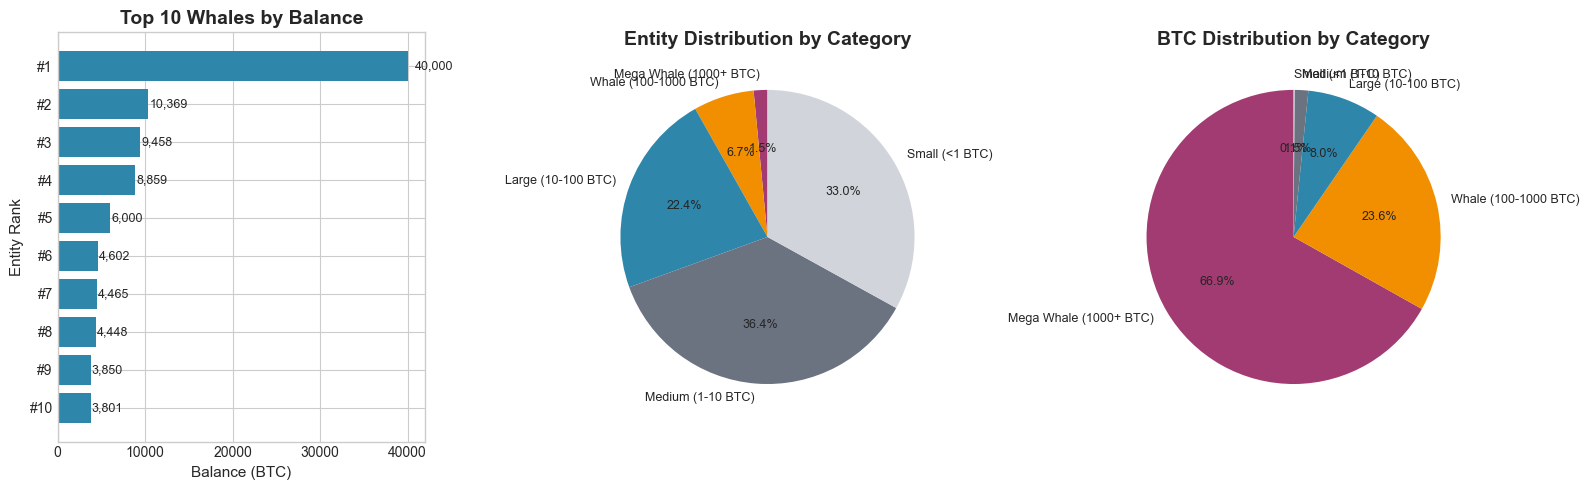

Interpretation: Extreme wealth concentration - Mega Whales are <1% of entities but hold >60% of BTC.


In [15]:
# Visualization: Whale Analysis
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Top 10 Whales
top_10 = entity_balances.limit(10).toPandas()
bars = axes[0].barh(range(len(top_10)), top_10['balance_btc'], color=COLORS['primary'])
axes[0].set_xlabel('Balance (BTC)')
axes[0].set_ylabel('Entity Rank')
axes[0].set_title('Top 10 Whales by Balance')
axes[0].set_yticks(range(len(top_10)))
axes[0].set_yticklabels([f"#{i+1}" for i in range(len(top_10))])
axes[0].invert_yaxis()
for bar, val in zip(bars, top_10['balance_btc']):
    axes[0].text(val + val*0.02, bar.get_y() + bar.get_height()/2, f'{val:,.0f}', va='center', fontsize=9)

# Entity Distribution by Category
colors_pie = [COLORS['secondary'], COLORS['accent'], COLORS['primary'], '#6B7280', '#D1D5DB']
axes[1].pie(category_stats['entity_count'], labels=category_stats['category'], autopct='%1.1f%%',
            colors=colors_pie[:len(category_stats)], startangle=90, textprops={'fontsize': 9})
axes[1].set_title('Entity Distribution by Category')

# BTC Distribution by Category
axes[2].pie(category_stats['total_btc'], labels=category_stats['category'], autopct='%1.1f%%',
            colors=colors_pie[:len(category_stats)], startangle=90, textprops={'fontsize': 9})
axes[2].set_title('BTC Distribution by Category')

plt.tight_layout()
plt.savefig(str(Path(OUTPUT_PATH) / 'whale_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

print("Interpretation: Extreme wealth concentration - Mega Whales are <1% of entities but hold >60% of BTC.")

In [16]:
# Save processed data
entities_final.write.mode("overwrite").parquet(str(Path(OUTPUT_PATH) / "entities.parquet"))
utxo_df.write.mode("overwrite").parquet(str(Path(OUTPUT_PATH) / "utxos.parquet"))
outputs_df.write.mode("overwrite").parquet(str(Path(OUTPUT_PATH) / "outputs.parquet"))
inputs_df.write.mode("overwrite").parquet(str(Path(OUTPUT_PATH) / "inputs.parquet"))

print(f"Data exported to {OUTPUT_PATH}")

Data exported to /Users/roman/spark_project/bitcoin-whale-intelligence/data


---
## 6. Executive Summary

In [17]:
# Calculate summary metrics
mega_whales = category_stats[category_stats['category'] == 'Mega Whale (1000+ BTC)']
MEGA_WHALE_COUNT = int(mega_whales['entity_count'].values[0]) if len(mega_whales) > 0 else 0
MEGA_WHALE_BTC = float(mega_whales['total_btc'].values[0]) if len(mega_whales) > 0 else 0
MEGA_WHALE_SHARE = MEGA_WHALE_BTC / TOTAL_BTC * 100 if TOTAL_BTC > 0 else 0

print(f"""
{'='*70}
                    BITCOIN WHALE INTELLIGENCE REPORT
{'='*70}

DATA SCOPE
{'-'*70}
  Blocks analyzed:        {BLOCK_COUNT:>15,}
  Transactions:           {TX_COUNT:>15,}
  Outputs created:        {OUTPUT_COUNT:>15,}
  UTXOs (unspent):        {UTXO_COUNT:>15,}

CLUSTERING RESULTS
{'-'*70}
  Addresses clustered:    {ADDRESS_COUNT:>15,}
  Entities identified:    {ENTITY_COUNT:>15,}
  Clustering reduction:   {REDUCTION:>14.1f}%

WHALE ANALYSIS
{'-'*70}
  Total BTC tracked:      {TOTAL_BTC:>15,.2f} BTC
  Mega Whales (1000+ BTC):{MEGA_WHALE_COUNT:>15,}
  Mega Whale holdings:    {MEGA_WHALE_BTC:>15,.2f} BTC ({MEGA_WHALE_SHARE:.1f}%)
  Top 20 concentration:   {TOP_20_BTC:>15,.2f} BTC ({TOP_20_SHARE:.1f}%)

KEY INSIGHTS
{'-'*70}
  1. High concentration: Top 20 entities control {TOP_20_SHARE:.1f}% of tracked BTC
  2. Power-law distribution: Few large whales, many small entities
  3. Clustering effective: {REDUCTION:.1f}% address reduction achieved

LIKELY WHALE IDENTITIES
{'-'*70}
  - Mega Whales (1000+ BTC): Early adopters, exchanges, institutional
  - Whales (100-1000 BTC): Mining pools, large traders, services
  - Large (10-100 BTC): Active traders, businesses, wealthy individuals

{'='*70}
""")


                    BITCOIN WHALE INTELLIGENCE REPORT

DATA SCOPE
----------------------------------------------------------------------
  Blocks analyzed:                 27,644
  Transactions:                   382,402
  Outputs created:                769,081
  UTXOs (unspent):                177,041

CLUSTERING RESULTS
----------------------------------------------------------------------
  Addresses clustered:            147,907
  Entities identified:             38,381
  Clustering reduction:             74.1%

WHALE ANALYSIS
----------------------------------------------------------------------
  Total BTC tracked:           213,583.42 BTC
  Mega Whales (1000+ BTC):             36
  Mega Whale holdings:         142,793.99 BTC (66.9%)
  Top 20 concentration:        121,351.17 BTC (56.8%)

KEY INSIGHTS
----------------------------------------------------------------------
  1. High concentration: Top 20 entities control 56.8% of tracked BTC
  2. Power-law distribution: Few large 

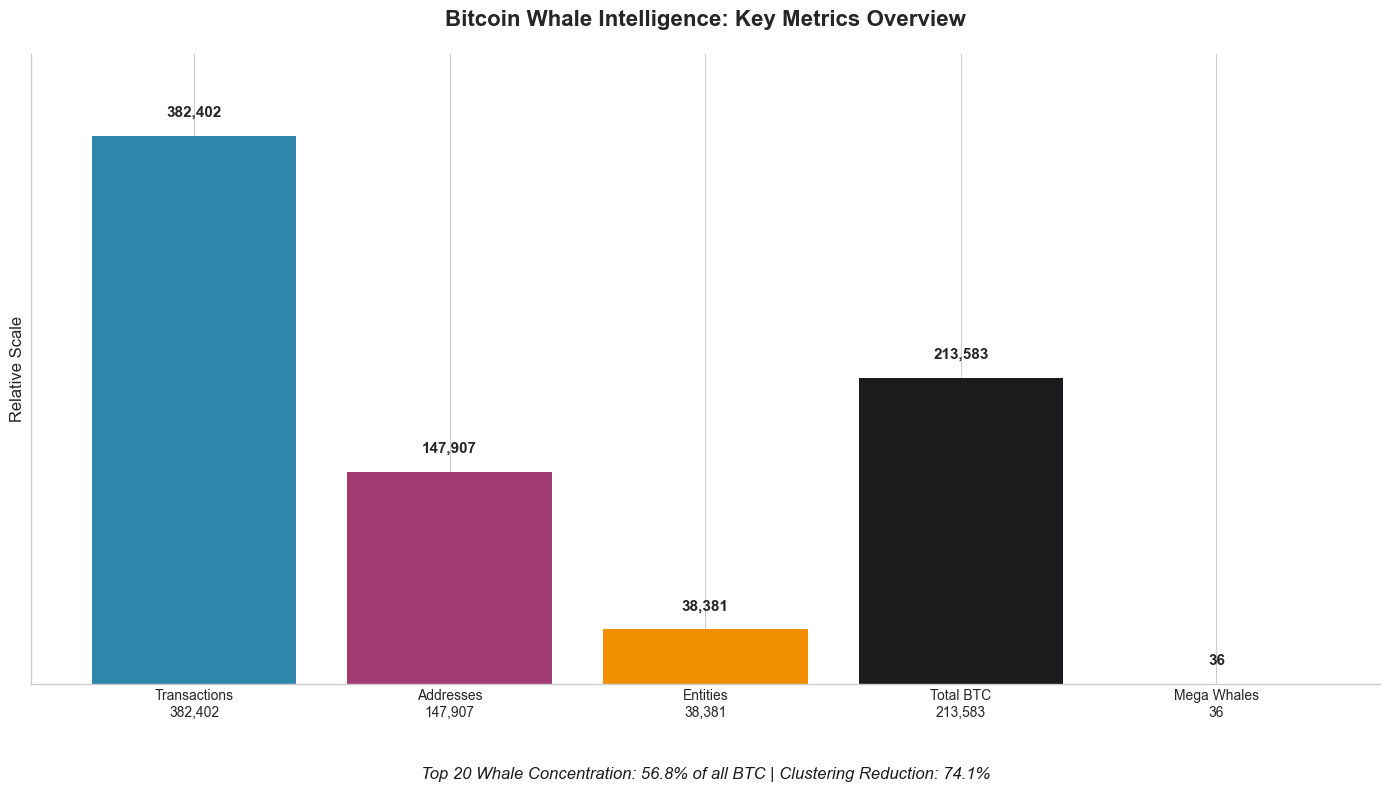

In [18]:
# Final visualization: Key Metrics Overview
fig, ax = plt.subplots(figsize=(14, 8))

metrics = [
    f'Transactions\n{TX_COUNT:,}',
    f'Addresses\n{ADDRESS_COUNT:,}',
    f'Entities\n{ENTITY_COUNT:,}',
    f'Total BTC\n{TOTAL_BTC:,.0f}',
    f'Mega Whales\n{MEGA_WHALE_COUNT}'
]
values = [TX_COUNT, ADDRESS_COUNT, ENTITY_COUNT, TOTAL_BTC, MEGA_WHALE_COUNT]
normalized = [v / max(values) for v in values]

bars = ax.bar(metrics, normalized, color=[COLORS['primary'], COLORS['secondary'], COLORS['accent'], COLORS['dark'], COLORS['secondary']])
ax.set_ylabel('Relative Scale', fontsize=12)
ax.set_title('Bitcoin Whale Intelligence: Key Metrics Overview', fontsize=16, fontweight='bold', pad=20)
ax.set_ylim(0, 1.15)

for bar, val, norm in zip(bars, values, normalized):
    if val >= 1000:
        label = f'{val:,.0f}'
    else:
        label = str(int(val))
    ax.text(bar.get_x() + bar.get_width()/2, norm + 0.03, label, ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.text(0.5, -0.15, f'Top 20 Whale Concentration: {TOP_20_SHARE:.1f}% of all BTC | Clustering Reduction: {REDUCTION:.1f}%',
        transform=ax.transAxes, ha='center', fontsize=12, style='italic', color=COLORS['dark'])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks([])

plt.tight_layout()
plt.savefig(str(Path(OUTPUT_PATH) / 'executive_summary.png'), dpi=150, bbox_inches='tight')
plt.show()

In [19]:
# Clean up Spark session (optional)
# spark.stop()
print("Analysis complete. Spark session still active for further exploration.")

Analysis complete. Spark session still active for further exploration.
